<a href="https://colab.research.google.com/github/AnnaScibska/Deep_learning_flowers_data_set/blob/master/Copy_of_first_working_version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pathlib

Upload the data from kaggle

In [2]:
file = open('/content/kaggle.json', 'w')
file.write('{\"username\":\"freeanke\",\"key\":\"92b509cecb01045514b22adb0910675c\"}')
file.close()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

Import the files

In [0]:
data_dir = pathlib.Path('flowers/flowers')
file_arr = np.array(list(data_dir.glob('*/*.jpg')))
np.random.shuffle(file_arr)

In [0]:
img_size = 128

def applyConvolutionFilter(img, filter, channel):
  size_y = len(img[0])
  size_x = len(img)

  i_transformed = np.copy(img)

  for x in range(1,size_x-1):
    for y in range(1,size_y-1):
      output_pixel = 0.0
      output_pixel = output_pixel + (img[x - 1, y-1, channel] * filter[0][0])
      output_pixel = output_pixel + (img[x, y-1, channel] * filter[0][1])
      output_pixel = output_pixel + (img[x + 1, y-1, channel] * filter[0][2])
      output_pixel = output_pixel + (img[x-1, y, channel] * filter[1][0])
      output_pixel = output_pixel + (img[x, y, channel] * filter[1][1])
      output_pixel = output_pixel + (img[x+1, y, channel] * filter[1][2])
      output_pixel = output_pixel + (img[x-1, y+1, channel] * filter[2][0])
      output_pixel = output_pixel + (img[x, y+1, channel] * filter[2][1])
      output_pixel = output_pixel + (img[x+1, y+1, channel] * filter[2][2])
      output_pixel = output_pixel * 1
      if(output_pixel<0):
        output_pixel=0
      if(output_pixel>img_size):
        output_pixel=img_size
      i_transformed[x, y, channel] = output_pixel 

  return i_transformed

def applyFilterToChannels(img, filter):
  img = applyConvolutionFilter(img, filter, 0) 
  img = applyConvolutionFilter(img, filter, 1) 
  img = applyConvolutionFilter(img, filter, 2) 
  return img

def process_one_image(filepath, flip):
  img = 0
  try:
    img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED)
    if flip:
      img = cv2.flip(img, 1)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)

    ### process img with filter
    # sharpenFilter = [[0,-1,0], [-1,5,-1], [0,-1,0]]
    # img = applyFilterToChannels(img, sharpenFilter)
    img = img/255
    
  except Exception as e:
    print(str(e))

  return img

# def process_one_image_flipped_vertically(filepath):
#   img = 0
#   try:
#     img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED)
#     img = cv2.flip(img, 1)
#     img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)

#     ### process img with filter
#     # sharpenFilter = [[0,-1,0], [-1,5,-1], [0,-1,0]]
#     # img = applyFilterToChannels(img, sharpenFilter)
#     img = img/255
    
#   except Exception as e:
#     print(str(e))

#   return img

def translate_label_from_str_to_int(strlabel):
  labels = {
      "sunflower": 0,
      "rose": 1,
      "dandelion": 2,
      "daisy": 3,
      "tulip": 4
  }
  return labels.get(strlabel)

def translate_label_from_int_to_str(intlabel):
  labels = {
      0: "sunflower",
      1: "rose",
      2: "dandelion",
      3: "daisy",
      4: "tulip"
  }
  return labels.get(intlabel)

def loading_loop(filepaths, flip=False):

  dataset = []
  labels = []

  for path in filepaths:
    dataset.append(process_one_image( './' + str(path), flip))
    labels.append(translate_label_from_str_to_int(str(path).split('/')[-2]))

    if len(labels)%500 == 0:
      print(str(len(labels)) + '/' + str(len(filepaths)))

  return [ dataset, labels ]

class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

Load data

In [19]:
datas = loading_loop(file_arr)

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


In [20]:
np.random.shuffle(file_arr)
flipped_datas = loading_loop(file_arr, True)

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


In [0]:
datas[0] = datas[0] + flipped_datas[0]
datas[1] = datas[1] + flipped_datas[1]

In [22]:
len(datas[1])

8646

In [0]:
xs = datas[0]
ys = datas[1]

ds_size = len(datas[0])

testData = xs[:ds_size:5]
testLabel = ys[:ds_size:5]

trainData = np.delete(xs, slice(0, ds_size, 5), 0)
trainLabel = np.delete(ys, slice(0, ds_size, 5))

In [9]:
print(len(testData))
print(len(testLabel))
print(len(trainData))
print(len(trainLabel))

1730
1730
6916
6916


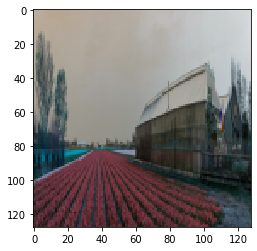

tulip


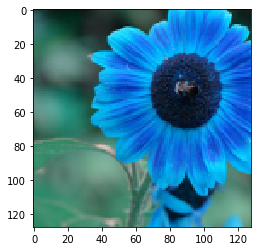

sunflower


In [24]:
from matplotlib import pyplot as plt

def gen_image(arr):
    
    plt.imshow(arr, interpolation='nearest')
    return plt

# Get a batch of two random images and show in a pop-up window.

nb = 500
gen_image(trainData[nb]).show()
print(translate_label_from_int_to_str(trainLabel[nb]))
gen_image(trainData[nb+1]).show()
print(translate_label_from_int_to_str(trainLabel[nb+1]))

In [0]:
# save data after first run
np.save('testData', testData)
np.save('trainData', trainData)
np.save('testLabel', testLabel)
np.save('trainLabel', trainLabel)

In [0]:
# restore data after crash
testData = np.load('testData.npy')
trainData = np.load('trainData.npy')

testLabel = np.load('testLabel.npy')
trainLabel = np.load('trainLabel.npy')

first model, accuracy 64

In [0]:
epochs=100
batch_size=100

In [0]:
callbacks = training_ceiling()

In [0]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.Dropout(0.1, input_shape=(128,128,3)), # accuracy: 0.4467 with batch_size=50
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),

    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [0]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), # learning_rate=0.001 accuracy: 0.5780 # learning_rate=0.005, beta_1=0.9, beta_2=0.999 # accuracy: 0.5942 with Adam() 
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)       

In [34]:
# model.fit(np.asarray(trainData), np.asarray(trainLabel), epochs=epochs, batch_size=batch_size, callbacks=[callbacks])
model.fit(np.asarray(trainData), np.asarray(trainLabel), validation_data=(np.asarray(testData),np.asarray(testLabel)), epochs=epochs, batch_size=batch_size, callbacks=[callbacks])

Epoch 1/100
70/70 [==============================] - 3s 40ms/step - loss: 1.3192 - accuracy: 0.4148 - val_loss: 1.0937 - val_accuracy: 0.5451
Epoch 2/100
70/70 [==============================] - 3s 37ms/step - loss: 1.0731 - accuracy: 0.5487 - val_loss: 1.0245 - val_accuracy: 0.5908
Epoch 3/100
70/70 [==============================] - 3s 37ms/step - loss: 0.9696 - accuracy: 0.6105 - val_loss: 0.9495 - val_accuracy: 0.6266
Epoch 4/100
70/70 [==============================] - 3s 37ms/step - loss: 0.8853 - accuracy: 0.6475 - val_loss: 1.2915 - val_accuracy: 0.5405
Epoch 5/100
70/70 [==============================] - 3s 38ms/step - loss: 0.8374 - accuracy: 0.6776 - val_loss: 0.8253 - val_accuracy: 0.6798
Epoch 6/100
70/70 [==============================] - 3s 38ms/step - loss: 0.7465 - accuracy: 0.7149 - val_loss: 0.8211 - val_accuracy: 0.6838
Epoch 7/100
70/70 [==============================] - 3s 37ms/step - loss: 0.7182 - accuracy: 0.7224 - val_loss: 0.7538 - val_accuracy: 0.7237
Epoch 

In [35]:
model.evaluate(np.asarray(testData), np.asarray(testLabel))

55/55 [==============================] - 0s 6ms/step - loss: 0.9641 - accuracy: 0.7728


[0.9641100168228149, 0.7728323936462402]